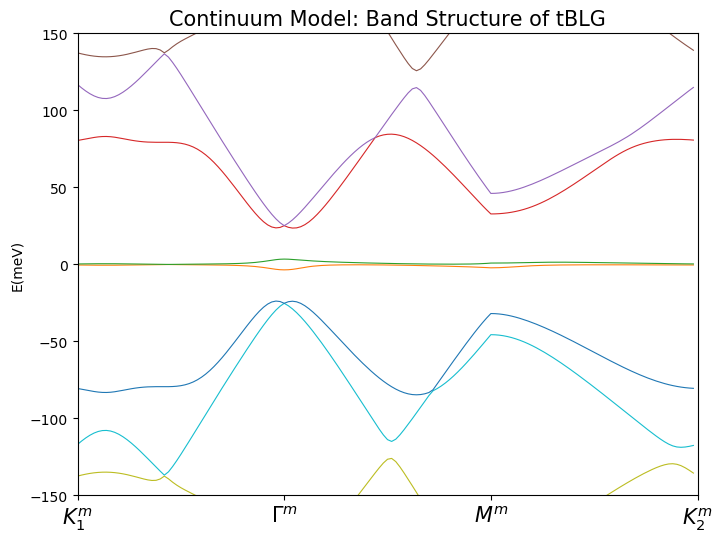

In [36]:
import numpy as np
import matplotlib.pyplot as plt

# Code is done with +k valley
# Parameters
theta = 1.05  # twist angle in degrees
theta = theta / 180.0 * np.pi  # Convert to radians
a = 0.246  # lattice constant in nm
vf = 2135.4 * a  # Fermi velocity in meV·angstrom
w0 = 75.2  # AA tunneling amplitude in meV
w1 = 97.5  # AB tunneling amplitude in meV
N = 4  # Truncate range
valley = 1  # Valley index
kdens = 100
k_spacing = 1 / kdens

# Define the rotation matrix
def rotation_matrix(theta):
    return np.array([
        [np.cos(theta), -np.sin(theta)],
        [np.sin(theta), np.cos(theta)]
    ])

# Pauli matrices
sigma_0 = np.array([[1, 0], [0, 1]], dtype=complex)
sigma_x = np.array([[0, 1], [1, 0]], dtype=complex)
sigma_y = np.array([[0, -1j], [1j, 0]], dtype=complex)

# Prefactor for moiré reciprocal lattice vectors
delk = 8 * np.pi * np.sin(theta / 2) / (a * np.sqrt(3))

# Moiré reciprocal lattice vectors
G1m = delk * np.array([-0.5, -np.sqrt(3) / 2])
G2m = delk * np.array([1, 0])
# Dirac points of mBZ
K1m = 8 * np.pi * np.sin(theta / 2) / (a * 3) * np.array([np.sqrt(3) / 2, -0.5])
K2m = 8 * np.pi * np.sin(theta / 2) / (a * 3) * np.array([np.sqrt(3) / 2, 0.5])

# Complex exponentials
phi = np.exp(2j * np.pi / 3)
phi_star = np.conjugate(phi)

# Define tunneling matrix using Pauli matrices
def tunneling_matrix(w0, w1, phase):
    return w0 * sigma_0 + w1 * (np.cos(phase) * sigma_x + np.sin(phase) * sigma_y)

# Construction of the relevant Tunneling matrices
T1 = tunneling_matrix(w0, w1, 0)
T2 = tunneling_matrix(w0, w1, -2 * np.pi / 3)
T3 = tunneling_matrix(w0, w1, 2 * np.pi / 3)

# Generate moiré lattice vectors
siteN = (2 * N + 1) ** 2
L = np.zeros((siteN, 2))
k = 0
for i in np.arange(2 * N + 1):
    for j in np.arange(2 * N + 1):
        L[k, 0] = i - N
        L[k, 1] = j - N
        k += 1

# Kronecker delta function
def kronecker_delta(i, j):
    return int(i == j)

# Hamiltonian function with Kronecker delta functions
def Hamiltonian(kx, ky):
    H = np.zeros((4 * siteN, 4 * siteN), dtype=complex)
    for i in range(siteN):
        n1 = L[i, 0]
        n2 = L[i, 1]
        
        q1 = np.array([kx, ky]) - K1m + n1 * G1m + n2 * G2m
        q2 = np.array([kx, ky]) - K2m + n1 * G1m + n2 * G2m
        
        H[2*i:2*i+2, 2*i:2*i+2] = -vf * (valley * q1[0] * sigma_x + q1[1] * sigma_y)
        H[2*i+2*siteN:2*i+2*siteN+2, 2*i+2*siteN:2*i+2*siteN+2] = -vf * (valley * q2[0] * sigma_x + q2[1] * sigma_y)
        
        for j in range(siteN):
            m1 = L[j, 0]
            m2 = L[j, 1]
            
            # Calculate Kronecker deltas
            kd_0 = kronecker_delta(m1, n1) * kronecker_delta(m2, n2) # Checks if delG = 0
            kd_G1 = kronecker_delta(m1, n1 - valley) * kronecker_delta(m2, n2) # Check if delG = G1m
            kd_G1G2 = kronecker_delta(m1, n1 - valley) * kronecker_delta(m2, n2 - valley)  # Check if delG = G1m + G2m
            
            # Combine with tunneling matrices
            T = kd_0 * T1 + kd_G1 * T2 + kd_G1G2 * T3

            # Update the Hamiltonian matrix
            H[2*i:2*i+2, 2*j+2*siteN:2*j+2*siteN+2] = T
            H[2*j+2*siteN:2*j+2*siteN+2, 2*i:2*i+2] = T.conjugate()

    return H

# k-space paths and band structure calculation

# Discretization of Paths

# Path 1 K1m to Gamma
P_1 = np.arange(-0.5, 0.0, k_spacing)
# Path 2 Gamma to Mm
P_2 = np.arange(0.0, 0.5, k_spacing)
# Path 3 Mm to K2m
P_3 = np.arange(0.5, 1.0, k_spacing)

k = 0
AllK = len(P_1) + len(P_2) + len(P_3) 
E = np.zeros((AllK, 4 * siteN), float)  

for i in range(0, len(P_1)):
    k = P_1[i]
    H = Hamiltonian(-np.sqrt(3) * k * delk, k * delk)
    eigvals = np.linalg.eigvalsh(H)  # Get eigenvalues
    E[i, :] = np.sort(np.real(eigvals))  # Sort and store them
                                               
for i in range(len(P_1), len(P_1) + len(P_2)):
    k = P_2[i - len(P_1)]
    H = Hamiltonian(np.sqrt(3) * k * delk, 0)
    eigvals = np.linalg.eigvalsh(H)
    E[i, :] = np.sort(np.real(eigvals))
                                               
for i in range(len(P_1) + len(P_2), AllK):
    k = P_3[i - len(P_1) - len(P_2)]
    H = Hamiltonian(np.sqrt(3) / 2 * delk, (k - 0.5) * delk)
    eigvals = np.linalg.eigvalsh(H)
    E[i, :] = np.sort(np.real(eigvals))
                                               

# Plotting the band structure
plt.figure(figsize=(8, 6))
# Plot the band structure with limits
for j in range(0, 4 * siteN):
    plt.plot(np.arange(AllK), E[:, j], linestyle="-", linewidth=0.8)

plt.title("Continuum Model: Band Structure of tBLG", fontsize=15)
plt.xlim(0, AllK)
plt.ylim(-150, 150)  # Set energy limits
plt.xticks([0, len(P_1), len(P_1) + len(P_2), AllK], 
           ['$K_1^m$', '$\\Gamma^m$', '$M^m$', '$K_2^m$'], fontsize=15)
plt.ylabel("E(meV)")
plt.show()
